<a href="https://colab.research.google.com/github/yeedinosor/OpenglRaytracer/blob/master/neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import math
import os

In [ ]:
def load_mnist_dataset(path):
  with np.load(path, allow_pickle=True) as f:
    train_images = f['x_train']/255
    train_labels = f['y_train']
    test_images = f['x_test']/255

    test_labels = f['y_test']


  return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = load_mnist_dataset("/content/mnist.npz")
train_images = np.array(train_images).reshape(60000, 28*28)
test_images = np.array(test_images).reshape(test_labels.size, 28*28)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#generate random weights/biases
sizes = np.array([train_images[0].size,10,10])
inputs = []
expected = np.zeros(10)
weights = []
biases = []
for i in range(1,sizes.size):
  weights.append(np.random.rand(sizes[i],sizes[i-1])-0.5)
  biases.append(np.zeros(sizes[i]))

In [ ]:
def sigmoid(x):
  return 1/(1+math.exp(-x))
def dsigmoid(x):
  return sigmoid(x)*(1-sigmoid(x))
def relu(x):
  return np.maximum(x,0)
def drelu(x):
  return x>0
def softmax(x):
  return np.exp(x) / sum(np.exp(x))

In [ ]:
a = []
z = []
def Activations():
  global a
  global z
  global inputs
  a = []
  z = []
  a.append(inputs)
  z.append(inputs)
  sum = 0
  for i in range(1, sizes.size):
    x = []
    y = []
    for j in range(sizes[i]):
        for k in range(sizes[i-1]):
          sum += weights[i-1][j][k]*a[i-1][k]
        x.append(relu(sum+biases[i-1][j]))
        y.append(sum+biases[i-1][j])
        sum = 0
    a.append(x)
    z.append(y)
  a[-1] = softmax(z[-1])
cost = [0,0,0,0,0,0,0,0,0,0]
def Cost():
  global cost
  global a
  global expected
  for i in range (10):
    cost[i] += (a[-1][i]-expected[i]) * (a[-1][i]-expected[i])

In [ ]:
def dCostdWeight(l, j, k):
  global inputs
  global cost
  global expected
  global weights
  global biases
  global a
  global z
  result = a[l-1][k]*dsigmoid(z[l][j])*dCostdA(l, j)
  return result
def dCostdBias(l, j):
  global inputs
  global cost
  global expected
  global weights
  global biases
  global a
  global z
  result = dsigmoid(z[l][j])*dCostdA(l, j)
  return result
def dCostdA(l, k):
  global inputs
  global cost
  global expected
  global weights
  global biases
  global a
  global z
  result = 0
  if(l == sizes.size-1):
    result = a[-1][k]-expected[k]
  else:
    for j in range(sizes[l+1]):
      result += weights[l][j][k]*dsigmoid(z[l+1][j])*dCostdA(l+1, j)
  return result

In [ ]:
weights[1][1][1]

0.2243981523017814

In [ ]:
# for x in range(1000):
#   for l in range(sizes.size-1):
#     for j in range(sizes[l+1]):
#       for k in range(sizes[l]):
#         weights[l][j][k]-= dCostdWeight(l,j,k)
#       biases[l][j]-= dCostdBias(l,j)
#       Activations()
#       Cost()
costGraph = []
def prop(batch_size):
  global inputs
  global cost
  global expected
  global weights
  global biases
  global a
  global z
  index = round(np.random.uniform(0, train_labels.size-1))
  inputs = train_images[index]
  expected = np.zeros(10)
  expected[train_labels[index]] = 1
  Activations()
  Cost()
dWeights = []
dBiases = []
# def bprop(batch_size, rate):
#   global inputs
#   global cost
#   global expected
#   global weights
#   global biases
#   global a
#   global z
#   global dWeights
#   global dBiases
#   for l in range(1, sizes.size):
#       for j in range(sizes[l]):
#         for k in range(sizes[l-1]):
#           dWeights[l-1][j][k] -= rate*dCostdWeight(l,j,k)/batch_size
#         dBiases[l-1][j] -= rate*dCostdBias(l,j)/batch_size
def bprop():
  global inputs
  global cost
  global expected
  global weights
  global biases
  global a
  global z
  global dWeights
  global dBiases
  m = 1
  dZ2 = a[2] - expected
  dWeights[1] -= 1 / m * dZ2.dot(a[1])
  dBiases[1] -= 1 / m * np.sum(dZ2)
  dZ1 = weights[1].T.dot(dZ2) * drelu(np.array(z[1]))
  dWeights[0] -= 1 / m * np.array([dZ1]).T.dot(np.array([inputs]))
  dBiases[0] -= 1 / m * np.sum(dZ1)
def train(epochs = 100, batch_size = 100, rate = 0.1):
  global inputs
  global cost
  global expected
  global weights
  global biases
  global a
  global z
  global dWeights
  global dBiases
  for e in range(epochs):
    cost = [0,0,0,0,0,0,0,0,0,0]
    dWeights = []
    dBiases = []
    for i in range(1,sizes.size):
      x = []
      dWeights.append(np.zeros((sizes[i],sizes[i-1])))
      dBiases.append(np.zeros(sizes[i]))
    for b in range(batch_size):
      prop(batch_size)
      bprop()
    for l in range(1, sizes.size):
      for j in range(sizes[l]):
        for k in range(sizes[l-1]):
          weights[l-1][j][k] += dWeights[l-1][j][k]
        biases[l-1][j] += dBiases[l-1][j]
    costGraph.append(np.sum(cost)/batch_size)
    print("epoch: " + str(e+1))
train()

epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59
epoch: 60
epoch: 61
epoch: 62
epoch: 63
epoch: 64
epoch: 65
epoch: 66
epoch: 67
epoch: 68
epoch: 69
epoch: 70
epoch: 71
epoch: 72
epoch: 73
epoch: 74
epoch: 75
epoch: 76
epoch: 77
epoch: 78
epoch: 79
epoch: 80
epoch: 81
epoch: 82
epoch: 83
epoch: 84
epoch: 85
epoch: 86
epoch: 87
epoch: 88
epoch: 89
epoch: 90
epoch: 91
epoch: 92
epoch: 93
epoch: 94
epoch: 95
epoch: 96
epoch: 97
epoch: 98
epoch: 99
epoch: 100


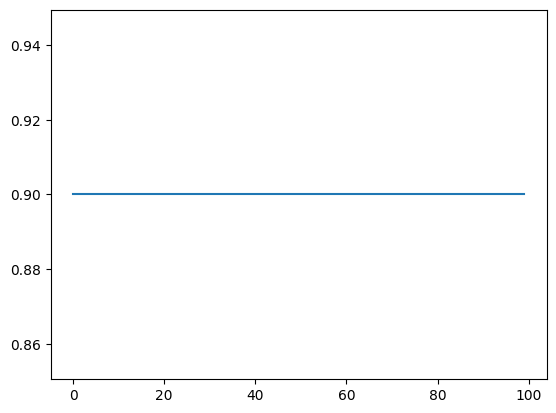

In [ ]:
plt.plot(costGraph)

In [ ]:
dZ2 = a[2] - expected
dZ1 = weights[1].T.dot(dZ2) * drelu(np.array(z[1]))
np.array(inputs).shape

(784,)

In [ ]:
expected

In [ ]:
print(costGraph)

In [ ]:
index = round(np.random.uniform(0, test_labels.size))
img = test_images[index]
inputs = img
Activations()

plt.imshow(img.reshape(28,28), cmap="gray")

print("expected: " + str(test_labels[index]))
print("result: " + str(a[-1].index(max(a[-1]))))
print(a[-1])
print(a[-1][a[-1].index(max(a[-1]))])
print(a[-1][test_labels[index]])

In [ ]:
accuracy = 0
for i in range(100):
  index = i
  img = test_images[index]
  inputs = img
  Activations()
  if(a[-1].index(max(a[-1])) == test_labels[index]):
    accuracy += 1/100
print(accuracy)

In [ ]:
print(round(np.size(test_labels)/10))